# Understand and prepare the ECCO data

Data is downloaded using the commands:

- wget -r --no-parent --user=keizer --password=dSWYu#c9nUqs#IEUHVX  https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_monthly/SSHDYN

- wget -r --no-parent --user=keizer --password=dSWYu#c9nUqs#IEUHVX  https://ecco.jpl.nasa.gov/drive/files/Version4/Release3/interp_monthly/SSH  

- wget -r --no-parent --user=keizer --password=dSWYu#c9nUqs#IEUHVX  https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_grid/   

Tutorial can be found here: https://ecco-v4-python-tutorial.readthedocs.io/index.html



In [1]:
import copy

import numpy as np
import xarray as xr
import pandas as pd
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

from scipy import signal
from IPython.utils import io

from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error



In [60]:
ecco_release4_nctiles_ssh = xr.open_mfdataset(f'/Users/iriskeizer/Documents/ROMS/data/ECCO4/global/nctiles/sshdyn/*.nc')
ecco_release3_interp = xr.open_mfdataset(f'/Users/iriskeizer/Documents/ROMS/data/ECCO4/global/interp/ssh_noIBcorrection/*.nc')
ecco_release4_nctiles_grid = xr.open_mfdataset(f'/Users/iriskeizer/Documents/ROMS/data/ECCO4/global/nctiles/grid/ECCO-GRID.nc')

ecco_release4_nctiles = xr.merge((ecco_release4_nctiles_grid, ecco_release4_nctiles_ssh))

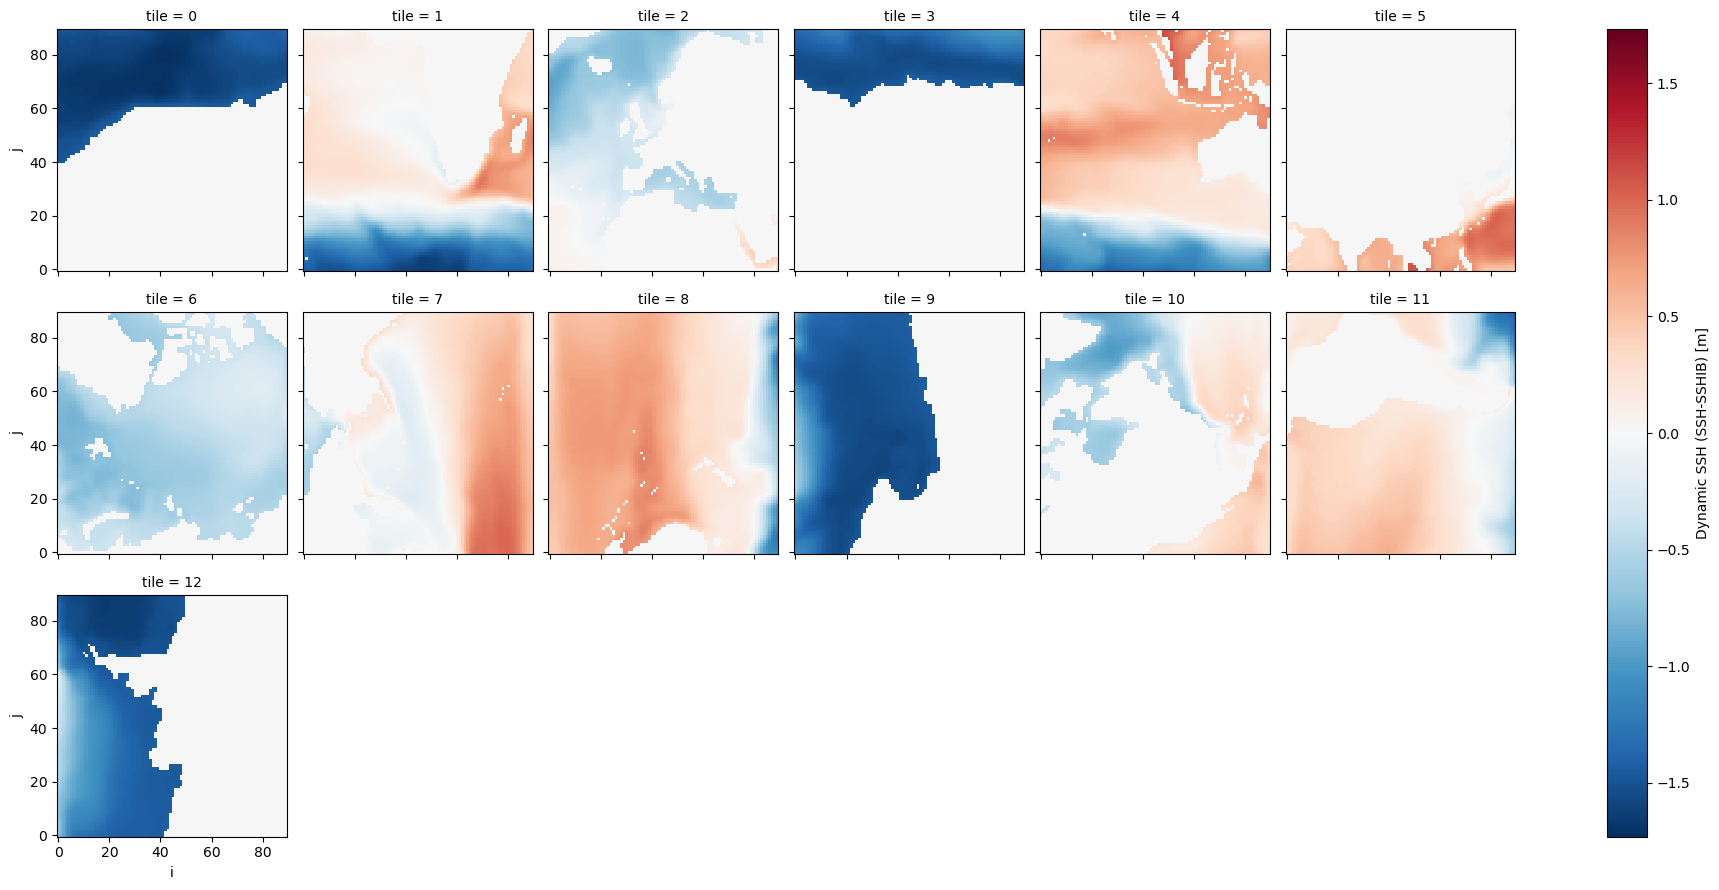

In [61]:
ecco_release4_nctiles.SSHDYN.isel(time=0).plot(col = 'tile', col_wrap = 6)

(<Figure size 900x1035 with 26 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

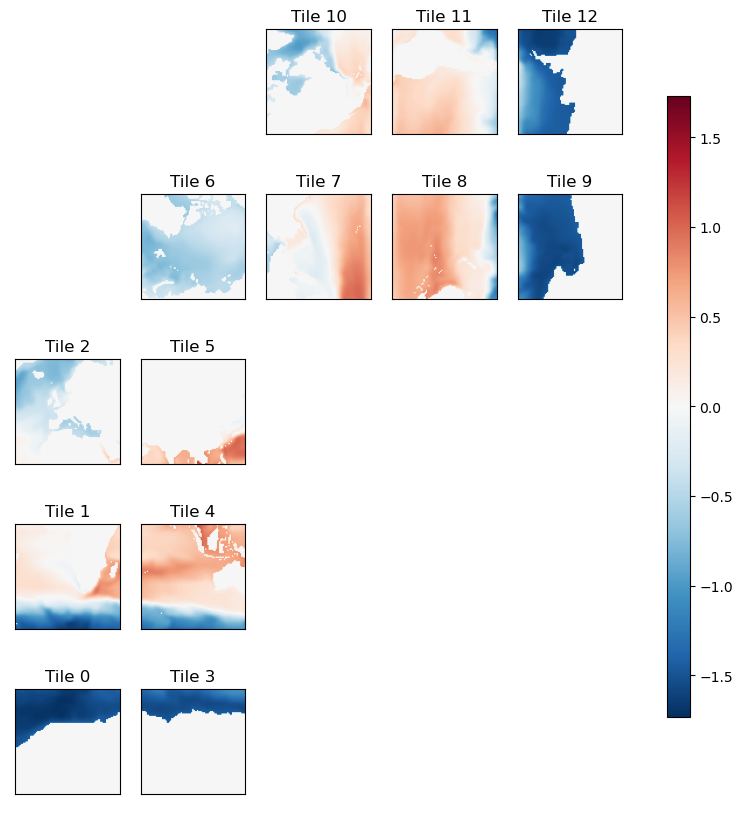

In [62]:
ecco.plot_tiles(ecco_release4_nctiles.SSHDYN.isel(time=0), show_colorbar = True)

(<Figure size 900x789 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

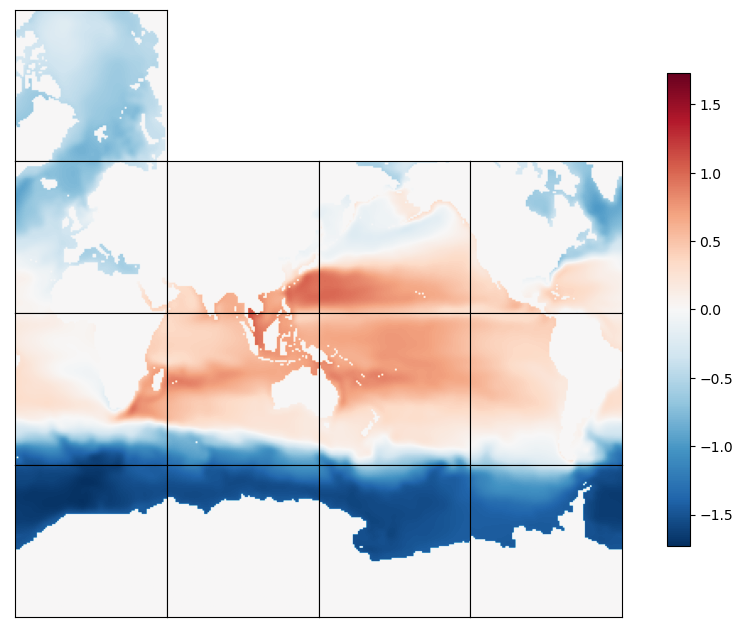

In [63]:
ecco.plot_tiles(ecco_release4_nctiles.SSHDYN.isel(time=0), show_colorbar = True, layout='latlon', rotate_to_latlon=True, show_tile_labels=False)

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


Text(0.5, 1.0, 'SSH corrected for IB effects [m]')

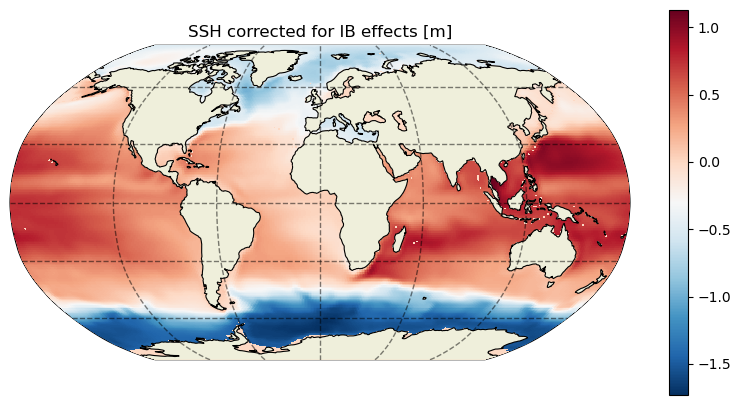

In [64]:
fig = plt.figure(figsize=(10,5))
ecco.plot_proj_to_latlon_grid(ecco_release4_nctiles.XC, ecco_release4_nctiles.YC, ecco_release4_nctiles.SSHDYN.isel(time=0), show_colorbar=True)
plt.title('SSH corrected for IB effects [m]')

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


Text(0.5, 1.0, 'SSH not corrected for IB effects [m]')

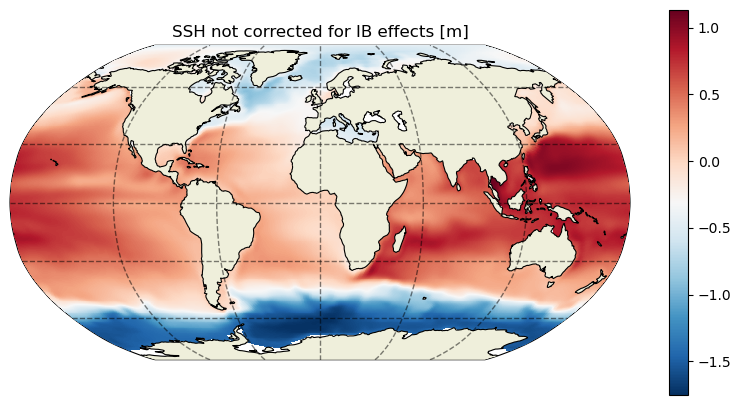

In [65]:
fig = plt.figure(figsize=(10,5))
ecco.plot_proj_to_latlon_grid(ecco_release3_interp.lon, ecco_release3_interp.lat, ecco_release3_interp.SSH.isel(i1=0), show_colorbar=True)
plt.title('SSH not corrected for IB effects [m]')

Text(0.5, 1.0, 'SSH corrected for IB effects [m]')

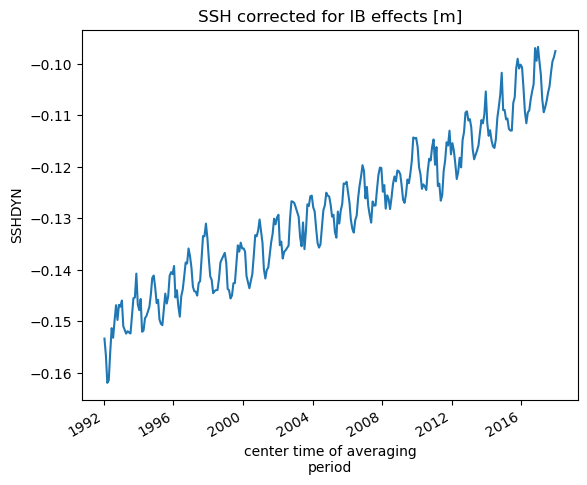

In [66]:
ecco_release4_nctiles.SSHDYN.mean(['tile', 'j', 'i']).plot()
plt.title('SSH corrected for IB effects [m]')

Text(0.5, 1.0, 'SSH not corrected for IB effects [m]')

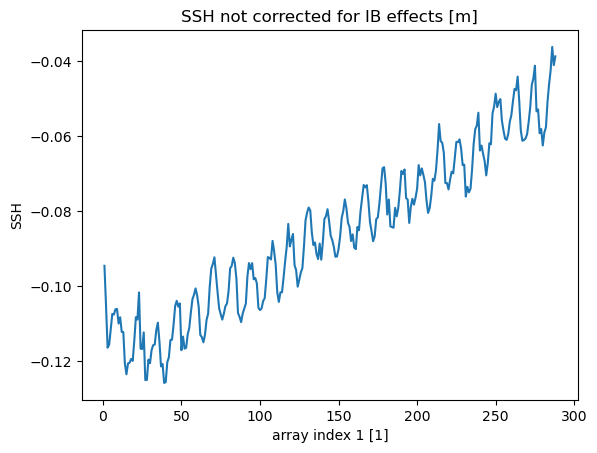

In [67]:
ecco_release3_interp.SSH.mean(['i2', 'i3']).plot()
plt.title('SSH not corrected for IB effects [m]')

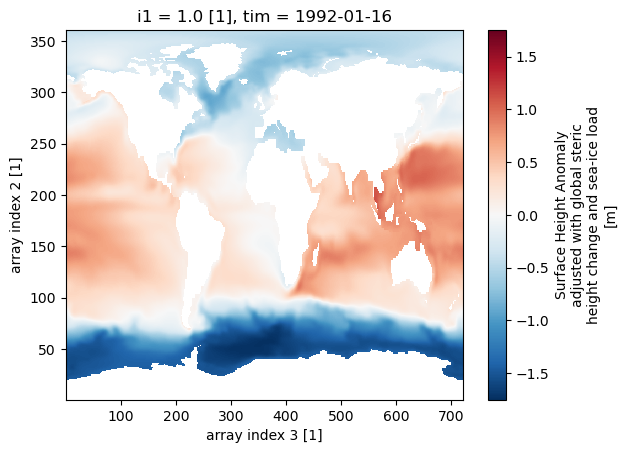

In [68]:
ecco_release3_interp.isel(i1=0).SSH.plot()

## Interpolating fields from the model llc grid to a regular lat lon grid

### Map to global latlon grid of 1° resolution using the nearest neighbour mapping method

In [69]:
help(ecco.resample_to_latlon)


Help on function resample_to_latlon in module ecco_v4_py.resample_to_latlon:

resample_to_latlon(orig_lons, orig_lats, orig_field, new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, radius_of_influence=120000, fill_value=None, mapping_method='bin_average')
    Take a field from a source grid and interpolate to a target grid.
    
    Parameters
    ----------
    orig_lons, orig_lats, orig_field : xarray DataArray or numpy array  :
        the lons, lats, and field from the source grid
    
        new_grid_min_lat, new_grid_max_lat : float
                latitude limits of new lat-lon grid
    
    new_grid_delta_lat : float
        latitudinal extent of new lat-lon grid cells in degrees (-90..90)
    
    new_grid_min_lon, new_grid_max_lon : float
                longitude limits of new lat-lon grid (-180..180)
    
    new_grid_delta_lon : float
         longitudinal extent of new lat-lon grid cells in degrees
    
    ra

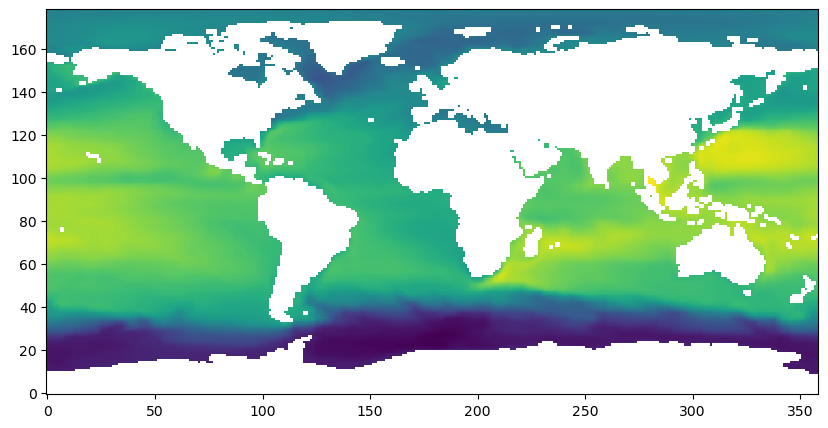

In [118]:
original_field_with_land_mask= np.where(ecco_release4_nctiles.maskC.isel(k=0)>0, ecco_release4_nctiles.SSHDYN.isel(time=0), np.nan)

new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90+new_grid_delta_lat/2
new_grid_max_lat = 90-new_grid_delta_lat/2

new_grid_min_lon = -180+new_grid_delta_lon/2
new_grid_max_lon = 180-new_grid_delta_lon/2

with io.capture_output() as captured:
    result = ecco.resample_to_latlon(ecco_release4_nctiles.XC, ecco_release4_nctiles.YC, 
                                                                             original_field_with_land_mask, new_grid_min_lat, new_grid_max_lat, 
                                                                             new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                                                             fill_value = np.NaN, mapping_method = 'nearest_neighbor', radius_of_influence = 120000);


new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result

# plot the whole field
plt.figure(figsize=(10,5))
plt.imshow(field_nearest_1deg,origin='lower')

In [97]:
# Create a new dataarray
SSH_ll_DA = xr.DataArray(field_nearest_1deg, name = 'SSHDYN', dims = ['latitude', 'longitude'], coords = {'latitude': new_grid_lat_centers[:,0],
                                                                                                          'longitude': new_grid_lon_centers[0,:]})

Text(0.5, 1.0, 'SSH corrected for IB effects [m]')

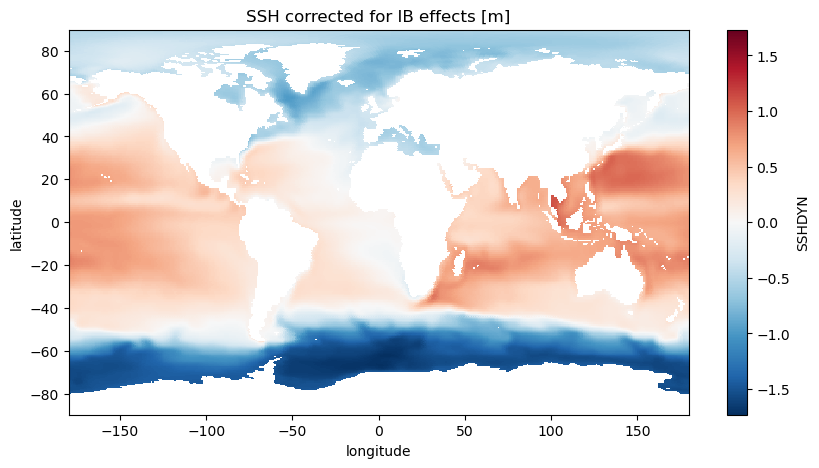

In [80]:
fig = plt.figure(figsize=(10,5))
SSH_ll_DA.plot()
plt.title('SSH corrected for IB effects [m]')

## Interpolate to latitude-longitude grid for whole dataset

In [74]:
help(ecco.resample_to_latlon)

Help on function resample_to_latlon in module ecco_v4_py.resample_to_latlon:

resample_to_latlon(orig_lons, orig_lats, orig_field, new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, radius_of_influence=120000, fill_value=None, mapping_method='bin_average')
    Take a field from a source grid and interpolate to a target grid.
    
    Parameters
    ----------
    orig_lons, orig_lats, orig_field : xarray DataArray or numpy array  :
        the lons, lats, and field from the source grid
    
        new_grid_min_lat, new_grid_max_lat : float
                latitude limits of new lat-lon grid
    
    new_grid_delta_lat : float
        latitudinal extent of new lat-lon grid cells in degrees (-90..90)
    
    new_grid_min_lon, new_grid_max_lon : float
                longitude limits of new lat-lon grid (-180..180)
    
    new_grid_delta_lon : float
         longitudinal extent of new lat-lon grid cells in degrees
    
    ra

In [149]:
def resample_to_latlon_2D(dataset_2d,  
                          new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, 
                          new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                          mapping_method, radius_of_influence):
    '''
    Function to perform the resampling on 2D fields which is given to the function 'apply_ufunc'
    '''
    original_field_with_land_mask = np.where(ecco_release4_nctiles.maskC.isel(k=0)>0, dataset_2d, np.nan)
        
    with io.capture_output() as captured:
        result = ecco.resample_to_latlon(ecco_release4_nctiles.XC, ecco_release4_nctiles.YC,
                                             original_field_with_land_mask, 
                                             new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                             new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                             fill_value = np.NaN, mapping_method = mapping_method, radius_of_influence = radius_of_influence)

    new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result

    result = field_nearest_1deg.copy()
    
    return result


def resample_to_latlon_3d(dataset, variable, resolution = 1.0, mapping_method = 'nearest_neighbor', radius_of_influence = 120000):
    '''
    Function to resample a global ECCO dataset to a latitude-longitude grid. Since the 'resample_to_latlon' function of ecco_v4_py does only work on 2D 
    datasets, it is combined in this function with 'apply_ufunc' to make it work on 3D datasets.
    
    '''
    
    
    # Define the new horizontal resolution
    new_grid_delta_lat = resolution
    new_grid_delta_lon = resolution
    
    
    # Define latitude minimum and maximum of new grid
    new_grid_min_lat = -90+new_grid_delta_lat/2
    new_grid_max_lat = 90-new_grid_delta_lat/2
    
    
    # Define longitude minimum and maximum of new grid
    new_grid_min_lon = -180+new_grid_delta_lon/2
    new_grid_max_lon = 180-new_grid_delta_lon/2
    
    # First perform for time=0
    original_field_with_land_mask = np.where(dataset.maskC.isel(k=0)>0, dataset[variable].isel(time=0), np.nan)
        
    with io.capture_output() as captured:
        result = ecco.resample_to_latlon(dataset.XC, dataset.YC,
                                             original_field_with_land_mask, 
                                             new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                             new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                             fill_value = np.NaN, mapping_method = mapping_method, radius_of_influence = radius_of_influence)

    new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result

    
    # Drop unnecesssary variables
    input_dataset = dataset[variable].drop(['XC', 'YC', 'CS', 'SN', 'Depth', 'rA', 'timestep'])
    
    # Obtain size output
    size_lat = (new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat
    size_lon = (new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon
    
    # Apply resampling 2D function on 3D dataarray
    result = xr.apply_ufunc(resample_to_latlon_2D,
                            input_dataset, 
                            new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, 
                            new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                            mapping_method, radius_of_influence,
                            input_core_dims = [['tile', 'j', 'i'], [], [], [], [], [], [], [], []],
                            output_core_dims = [['latitude', 'longitude']],
                            dask = 'parallelized',
                            dask_gufunc_kwargs = {'output_sizes': {'latitude': size_lat, 'longitude': size_lon}})
    
    # Add dimensions
    result = result.assign_coords(latitude = new_grid_lat_centers[:,0], longitude = new_grid_lon_centers[0,:])
    
    
    return result
    

In [150]:
SSH_ll_DA = resample_to_latlon_3d(ecco_release4_nctiles, 'SSHDYN')

In [151]:
SSH_ll_DA

<xarray.DataArray 'SSHDYN' (time: 312, latitude: 179, longitude: 359)>
dask.array<transpose, shape=(312, 179, 359), dtype=float32, chunksize=(1, 179, 359), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
  * latitude   (latitude) float64 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float64 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

In [152]:
SSH_ll_DA.isel(time=0, latitude=0, longitude=0).values

TypeError: radius_of_influence must be number

In [ ]:
global_mean = SSH_ll_DA.mean(['latitude', 'longitude']);

In [ ]:
global_mean.plot()

In [ ]:
def resample_to_latlon_3d(dataset, variable, resolution = 0.5, mapping_method = 'nearest_neighbor', radius_of_influence = 3000):
    '''
    Function to resample a global ECCO dataset to a latitude-longitude grid. Since the 'resample_to_latlon' function of ecco_v4_py does only work on 2D 
    datasets, it is combined in this function with 'apply_ufunc' to make it work on 3D datasets.
    
    '''
    
    # Define the new horizontal resolution
    new_grid_delta_lat = resolution
    new_grid_delta_lon = resolution
    
    # Define latitude minimum and maximum of new grid
    new_grid_min_lat = -90+new_grid_delta_lat/2
    new_grid_max_lat = 90-new_grid_delta_lat/2
        
    # Define longitude minimum and maximum of new grid
    new_grid_min_lon = -180+new_grid_delta_lon/2
    new_grid_max_lon = 180-new_grid_delta_lon/2
    
    
    result = []
    
    for year in dataset.time:
            
        original_field_with_land_mask= np.where(ecco_release4_nctiles.maskC.isel(k=0)>0, ecco_release4_nctiles.SSHDYN.sel(time=year), np.nan)
            
        with io.capture_output() as captured:
            result_year = ecco.resample_to_latlon(dataset.XC, dataset.YC, original_field_with_land_mask, new_grid_min_lat, new_grid_max_lat, 
                                         new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                         fill_value = np.NaN, mapping_method = mapping_method, 
                                         radius_of_influence = radius_of_influence)
            
            new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result_year
            
            result.append(field_nearest_1deg)
            
    # Create a new dataarray
    DA = xr.DataArray(result, 
                      name = 'SSHDYN', 
                      dims = ['time', 'latitude', 'longitude'], 
                      coords = {'time': dataset.time, 'latitude': new_grid_lat_centers[:,0], 'longitude': new_grid_lon_centers[0,:]}) 
    
    
    return DA


In [ ]:
SSH_ll_DA_for = resample_to_latlon_3d(ecco_release4_nctiles, 'SSHDYN', resolution = 1.0)

In [ ]:
SSH_ll_DA_for

### Plot global mean ocean dynamic sea level

In [ ]:
global_mean = SSH_ll_DA_for.mean(['latitude', 'longitude']);

global_mean.plot()

In [ ]:
ecco_release4_nctiles.SSHDYN.mean(['tile', 'j', 'i']).plot()

### Correct ocean dynamic sea level for global mean

In [ ]:
SSH_ll_DA_for_cor = SSH_ll_DA_for - global_mean

In [ ]:
SSH_ll_DA_for.isel(time=0).plot()

In [ ]:
SSH_ll_DA_for_cor.isel(time=0).plot()

### Obtain annual averages

In [ ]:
SSH_ll_DA_for_cor_an = SSH_ll_DA_for_cor.groupby('time.year').mean().rename({'year': 'time'})


### Obtain ocean dynamic sea level along the Dutch coast

In [ ]:
def sea_level_tide_gauges(dataset):
    '''
    Function to select data near the six tide gauges along the Dutch coast from a dataarray.
    '''
    
    stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']
    
    def station_coords(): 
        """
        Function to obtain the coordinates of the tide gauge stations as a dataframe

        """

        # Necessary declarations to obtain tide gauge station coordinates
        path_locations = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/rlr_annual/filelist.txt'
        loc_num = [20, 22, 23, 24, 25, 32]
        col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']

        # Create dataframe
        df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
        df = df.set_index('id')
        df = df.loc[loc_num, :]
        df['name'] = stations[:-1]
        df = df.set_index('name')
        df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)

        return df


    coord_df = station_coords()
    
    
    df = pd.DataFrame({'time' : dataset.time}).set_index('time')

    for station in coord_df.index:
        
        if station == 'Vlissingen':
            data_stat = dataset.sel(longitude = coord_df['lon'][station]-0.1, latitude = coord_df['lat'][station], method = 'Nearest').values
        
        elif station == 'Delfzijl':
            data_stat = dataset.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station]+0.2, method = 'Nearest').values
        
        else:
            data_stat = dataset.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], method = 'Nearest').values

        # Obtain anomaly
        data_stat_anom = data_stat - data_stat[0] 

        # Save in dataframe
        df[station] = data_stat_anom

    df['Average'] = df.mean(axis=1)
    
    
    return df

In [ ]:
ecco_ssh_tg = sea_level_tide_gauges(SSH_ll_DA_for_cor_an)

In [ ]:
# Obtain array of average data
ecco_tg_ocdyn = ecco_ssh_tg['Average'].values*100

In [ ]:
# Obtain anomalies compared to 1993
ecco_tg_ocdyn = ecco_tg_ocdyn - ecco_tg_ocdyn[1]

In [ ]:
# Obtain time array
ecco_tg_time = ecco_ssh_tg.index.values

### Import ocean dynamic sea level of other (reanalysis) products for comparison

In [ ]:
# Reanalysis products
glorys_tg_ocdyn = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/glorys_tg_ocdyn.csv', index_col = 'time')['Average'].values*100
soda_tg_ocdyn = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/sealevel_soda_tg.csv', index_col = 'time')['Average'].values*100


# Obtain anomalies compared to 1993
glorys_tg_ocdyn = glorys_tg_ocdyn - glorys_tg_ocdyn[0]
soda_tg_ocdyn = soda_tg_ocdyn - soda_tg_ocdyn[13]


# Budget
budget_tg = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/budget/slbudget_2022_11_23_All_NL_tide_gauge_1993_2021_ERA5_StericEN4_22_[500, 4000]m.csv', index_col = 'time')

budget_tg_wind = budget_tg['Wind'].values - budget_tg['Wind'].iloc[0]
budget_tg_steric = budget_tg['LocSteric'].values - budget_tg['LocSteric'].iloc[0]
budget_tg_ocdyn = budget_tg_wind + budget_tg_steric


# Obtain time arrays
glorys_tg_time = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/glorys_tg_ocdyn.csv', index_col = 'time').index.values
soda_tg_time = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/tg_ocdyn/sealevel_soda_tg.csv', index_col = 'time').index.values
budget_tg_time = budget_tg.index.values

### Plot comparison of ocean dynamic sea level

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (8,6.5))

ax = axes[0]

# Plot budget
ax.plot(budget_tg_time, budget_tg_ocdyn, color = 'k')

# Plot glorys output
ax.plot(glorys_tg_time, glorys_tg_ocdyn)

# Plot soda output
ax.plot(soda_tg_time, soda_tg_ocdyn)

# Plot ecco output
ax.plot(ecco_tg_time, ecco_tg_ocdyn)


# Obtain linear trend
budget_trend = round(np.polyfit(budget_tg_time[:-4], budget_tg_ocdyn[:-4]*10, 1)[0],2)
glorys_trend = round(np.polyfit(glorys_tg_time[:-3], glorys_tg_ocdyn[:-3]*10, 1)[0],2)
soda_trend = round(np.polyfit(soda_tg_time[13:-3], soda_tg_ocdyn[13:-3]*10, 1)[0],2)
ecco_trend = round(np.polyfit(ecco_tg_time[1:], ecco_tg_ocdyn[1:]*10, 1)[0],2)
   

# Add plot settings  
ax.set_xlabel('Time [yr]', fontsize = 12)
ax.set_ylabel('Sea level [cm]', fontsize = 12)
ax.set_title(f'Ocean dynamic sea level anomaly along the Dutch coast', fontsize = 13)
ax.set_xticks(range(1980, 2021, 10), fontsize = 12)
ax.set_ylim(-13,8)
ax.set_yticks([-10, -5, 0, 5], fontsize = 12)
ax.grid()


# Add label
labels=['budget', 'glorys', 'soda', 'ecco']
ax.legend(labels = labels, fontsize = 13, loc='center left', bbox_to_anchor=(1.0, 0.5))



# Detrend data
budget_dt = signal.detrend(budget_tg_ocdyn[:-4])
glorys_dt = signal.detrend(glorys_tg_ocdyn[:-3])
soda_dt = signal.detrend(soda_tg_ocdyn[13:-3])
ecco_dt = signal.detrend(ecco_tg_ocdyn[1:])


# Obtain correlations
r_glorys_budget = np.round(np.corrcoef(glorys_dt, budget_dt)[0,1], 3)
r_soda_budget = np.round(np.corrcoef(soda_dt, budget_dt)[0,1], 3)
r_ecco_budget = np.round(np.corrcoef(ecco_dt, budget_dt)[0,1], 3)

r_soda_glorys = np.round(np.corrcoef(soda_dt, glorys_dt)[0,1], 3)
r_ecco_glorys = np.round(np.corrcoef(ecco_dt, glorys_dt)[0,1], 3)

r_ecco_soda = np.round(np.corrcoef(ecco_dt, soda_dt)[0,1], 3)


# Make table of correlations
table_labels=['budget','glorys', 'soda', 'ecco']
table_vals=[['x',r_glorys_budget,r_soda_budget,r_ecco_budget],
            [r_glorys_budget,'x',r_soda_glorys,r_ecco_glorys],
           [r_soda_budget,r_soda_glorys,'x',r_ecco_soda],
           [r_ecco_budget,r_ecco_glorys,r_ecco_soda,'x']]

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table = axes[1].table(cellText=table_vals,
                  colWidths = [0.18]*5,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=table_labels,
                         loc = 'upper center')

# Make table of linear trends
the_secon_table = axes[1].table(cellText=[[str(budget_trend)], [str(glorys_trend)], [str(soda_trend)], [str(ecco_trend)]],
                  colWidths = [0.3]*4,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=['Linear trends [mm/yr]'],
                         loc = 'lower center')


    
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/ECCO/comparison_ocdyn_wind_steric/ocdyn_sealevel_tg', bbox_inches="tight")

### Obtain wind-driven sea level along the Dutch coast

In [ ]:
# Import wind stress data 
windstress = pd.read_csv('/Users/iriskeizer/Documents/Zeespiegelscenarios/data/wind stress/windstress.csv', index_col = 'time')

windstress.columns = [     ('Vlissingen', '$U \sqrt{u^2+v^2}$'),
            ('Vlissingen', '$V \sqrt{u^2+v^2}$'),
       ('Hoek v. Holland', '$U \sqrt{u^2+v^2}$'),
       ('Hoek v. Holland', '$V \sqrt{u^2+v^2}$'),
            ('Den Helder', '$U \sqrt{u^2+v^2}$'),
            ('Den Helder', '$V \sqrt{u^2+v^2}$'),
              ('Delfzijl', '$U \sqrt{u^2+v^2}$'),
              ('Delfzijl', '$V \sqrt{u^2+v^2}$'),
             ('Harlingen', '$U \sqrt{u^2+v^2}$'),
             ('Harlingen', '$V \sqrt{u^2+v^2}$'),
              ('IJmuiden', '$U \sqrt{u^2+v^2}$'),
              ('IJmuiden', '$V \sqrt{u^2+v^2}$'),
               ('Average', '$U \sqrt{u^2+v^2}$'),
               ('Average', '$V \sqrt{u^2+v^2}$')]

#### Perform regression

In [ ]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']
path = '/Users/iriskeizer/Documents/ROMS/data/wind effect'

def regression(sea_data, wind_data):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.index - wind_data.index[0]
    
    
    
    # Create lists containing names of regression terms
    regg_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$', 'trend']
    wind_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    
    
    # Create lists to save datasets
    timeseries_lst = []
    netcdf_lst = []
    reg_results_lst = []
    coef_lst = []
    intercept_lst = []
    rmse_lst = []
    R2_total_lst = []
    R2_wind_lst = []
    R2_u2_lst = []
    R2_v2_lst = []
    
    # Perform regression for each station
    for station in stations:
        
        # Create dataframe for y 
        y = sea_data[station]
    
        # Create dataframe for x
        x = pd.DataFrame(data={'time': wind_data.index,
                              '$U \sqrt{u^2+v^2}$': wind_data[station, '$U \sqrt{u^2+v^2}$'],
                              '$V \sqrt{u^2+v^2}$': wind_data[station, '$V \sqrt{u^2+v^2}$'],
                              'trend': trend,})
        
        x = x.set_index('time')
        
        # Define regression
        regression_ = linr()
        
        
        # Interpolate to remove nan values
        x = x.interpolate(axis=0)
        y = y.interpolate(axis=0)
        
        
        # Standardize x
        scaler = StandardScaler()
        x = copy.deepcopy(x)
        x.iloc[:,:] = scaler.fit_transform(x)
        
        
        # Create copy such that regression result can be obtained for full timeseries
        x_timeseries = copy.deepcopy(x)
        
        
        # Create dataframes of equal time span
        y = y[y.index.isin(x.index)]
        x = x[x.index.isin(y.index)]
        
        
        # Fit the regression model and add results to lists
        fit = regression_.fit(x,y)
        score = regression_.score(x,y) # R^2 for the whole regression including the trend 
        intercept_lst.append(regression_.intercept_)
        coef_lst.append(regression_.coef_.tolist())
        
        
        # Calculate rmse
        yhat = regression_.predict(x)
        mse = mean_squared_error(y, yhat) # Calculate insample mse
        rmse_lst.append(np.sqrt(mse))
        
        
        # Obtain dataframe containing timeseries resulting from regression
        df = pd.DataFrame(data=dict(time=x_timeseries.index))
        df = df.set_index('time')
        
        for i in range(len(regg_names)):
            df[regg_names[i]] = coef_lst[-1][i] * x_timeseries[x_timeseries.columns[i]]
            
        df['total'] = df.sum(axis=1)
        df['wind total'] = df[wind_names].sum(axis=1)
        
        # Add dataframe to list 
        timeseries_lst.append(df)
        
        netcdf_lst.append(xr.Dataset(data_vars=dict(u2=(['time'],  df['$U \sqrt{u^2+v^2}$'].values),
                                                    v2=(['time'],  df['$V \sqrt{u^2+v^2}$'].values),
                                                    trend=(['time'],  df['trend'].values),
                                                    total=(['time'],  df['total'].values),
                                                    wind_total=(['time'],  df['wind total'].values),
                                                    time = df.index.values)))
        
        # Calculate R^2 values
        R2_total_lst.append(score) # R^2 for the whole regression including the trend
        R2_wind_lst.append(R2_var(df, y, 'wind total', regression_))
        R2_u2_lst.append(R2_var(df, y, '$U \sqrt{u^2+v^2}$', regression_))
        R2_v2_lst.append(R2_var(df, y, '$V \sqrt{u^2+v^2}$', regression_))
                

            
    # Create dataframe of timeseries
    timeseries_df = pd.concat(timeseries_lst, axis=1, keys = stations)      
    timeseries_nc = xr.concat(netcdf_lst, dim=stations).rename({"concat_dim":"station"})       
    
    # Save netcdf file
    timeseries_nc.to_netcdf(f'{path}/timeseries_soda.nc')
    
    
    
    # Create dataframe of coefficients
    
    # Transpose coef list
    numpy_array = np.array(coef_lst)
    transpose = numpy_array.T
    coef_lst_T = transpose.tolist()
    
    results_df = pd.DataFrame(data={'station': stations, 
                                    'R$^2$' : R2_total_lst,
                                    'R$^2_{wind}$' : R2_wind_lst,
                                    'R$^2_{U \sqrt{u^2+v^2}}$' : R2_u2_lst,
                                    'R$^2_{V \sqrt{u^2+v^2}}$' : R2_v2_lst,
                                    'RMSE': rmse_lst, 
                                    'constant' : intercept_lst})
    
    
    
    for i in range(len(coef_lst_T)):
        results_df[regg_names[i]] = coef_lst_T[i]
        
    results_df = results_df.set_index('station')
     
        
    results_nc = xr.Dataset(data_vars=dict(r2=(['station'], R2_total_lst),
                                                        r2_wind=(['station'], R2_wind_lst),
                                                        r2_u2=(['station'], R2_u2_lst),
                                                        r2_v2=(['station'], R2_v2_lst),
                                                        rmse=(['station'], rmse_lst),
                                                        constant=(['station'], intercept_lst),
                                                        u2=(['station'], coef_lst_T[0]),
                                                        v2=(['station'], coef_lst_T[1]),
                                                        trend=(['station'], coef_lst_T[2]),
                                                        station = stations))
    
    
    # Save netcdf file
    results_nc.to_netcdf(f'{path}/results_soda.nc')
    
    
    return(results_nc, timeseries_nc)


    
    
def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', '$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    """
    
    x = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x = x.set_index('time')
    x = x[x.index.isin(y.index)]
    
    fit = regression_.fit(x, y)
    score = regression_.score(x,y)
    
    return score


In [ ]:
ecco_ssh_tg

In [ ]:
ecco_results, timeseries_ecco = regression(ecco_ssh_tg, windstress)

In [ ]:
timeseries_ecco

In [ ]:
ecco_tg_wind = timeseries_ecco.sel(station = 'Average').wind_total.values*100

In [ ]:
# Obtain data from 1992 - 2017
ecco_tg_wind = ecco_tg_wind[12:-3]

In [ ]:
# Obtain anomalies compared to 1993
ecco_tg_wind = ecco_tg_wind - ecco_tg_wind[1]

### Import wind-driven sea level of other (reanalysis) products for comparison

In [ ]:
# Reanalysis products
glorys_tg_wind = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/wind effect/timeseries_glorys.nc').sel(station = 'Average').wind_total.values*100
soda_tg_wind = xr.open_dataset('/Users/iriskeizer/Documents/Zeespiegelscenarios/data/soda/regression output/timeseries_soda.nc').sel(station = 'Average').wind_total.values*100

# Obtain anomalies compared to 1993
glorys_tg_wind = glorys_tg_wind - glorys_tg_wind[0]
soda_tg_wind = soda_tg_wind - soda_tg_wind[13]



### Plot comparison of wind-driven sea level

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (8,6.5))

ax = axes[0]

# Plot budget
ax.plot(budget_tg_time, budget_tg_wind, color = 'k')

# Plot glorys output
ax.plot(glorys_tg_time, glorys_tg_wind)

# Plot soda output
ax.plot(soda_tg_time, soda_tg_wind)

# Plot ecco output
ax.plot(ecco_tg_time, ecco_tg_wind)


# Obtain linear trend
budget_trend = round(np.polyfit(budget_tg_time[:-4], budget_tg_wind[:-4]*10, 1)[0],2)
glorys_trend = round(np.polyfit(glorys_tg_time[:-3], glorys_tg_wind[:-3]*10, 1)[0],2)
soda_trend = round(np.polyfit(soda_tg_time[13:-3], soda_tg_wind[13:-3]*10, 1)[0],2)
ecco_trend = round(np.polyfit(ecco_tg_time[1:], ecco_tg_wind[1:]*10, 1)[0],2)
   

# Add plot settings  
ax.set_xlabel('Time [yr]', fontsize = 12)
ax.set_ylabel('Sea level [cm]', fontsize = 12)
ax.set_title(f'Wind-driven sea level anomaly along the Dutch coast', fontsize = 13)
ax.set_xticks(range(1980, 2021, 10), fontsize = 12)
ax.set_ylim(-13,8)
ax.set_yticks([-10, -5, 0, 5], fontsize = 12)
ax.grid()


# Add label
labels=['budget', 'glorys', 'soda', 'ecco']
ax.legend(labels = labels, fontsize = 13, loc='center left', bbox_to_anchor=(1.0, 0.5))



# Detrend data
budget_dt = signal.detrend(budget_tg_wind[:-4])
glorys_dt = signal.detrend(glorys_tg_wind[:-3])
soda_dt = signal.detrend(soda_tg_wind[13:-3])
ecco_dt = signal.detrend(ecco_tg_wind[1:])


# Obtain correlations
r_glorys_budget = np.round(np.corrcoef(glorys_dt, budget_dt)[0,1], 3)
r_soda_budget = np.round(np.corrcoef(soda_dt, budget_dt)[0,1], 3)
r_ecco_budget = np.round(np.corrcoef(ecco_dt, budget_dt)[0,1], 3)

r_soda_glorys = np.round(np.corrcoef(soda_dt, glorys_dt)[0,1], 3)
r_ecco_glorys = np.round(np.corrcoef(ecco_dt, glorys_dt)[0,1], 3)

r_ecco_soda = np.round(np.corrcoef(ecco_dt, soda_dt)[0,1], 3)


# Make table of correlations
table_labels=['budget','glorys', 'soda', 'ecco']
table_vals=[['x',r_glorys_budget,r_soda_budget,r_ecco_budget],
            [r_glorys_budget,'x',r_soda_glorys,r_ecco_glorys],
           [r_soda_budget,r_soda_glorys,'x',r_ecco_soda],
           [r_ecco_budget,r_ecco_glorys,r_ecco_soda,'x']]

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table = axes[1].table(cellText=table_vals,
                  colWidths = [0.18]*5,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=table_labels,
                         loc = 'upper center')

# Make table of linear trends
the_secon_table = axes[1].table(cellText=[[str(budget_trend)], [str(glorys_trend)], [str(soda_trend)], [str(ecco_trend)]],
                  colWidths = [0.3]*4,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=['Linear trends [mm/yr]'],
                         loc = 'lower center')


    
plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/ECCO/comparison_ocdyn_wind_steric/wind_sealevel_tg', bbox_inches="tight")

### Obtain regional steric sea level along the Dutch coast

In [ ]:
glorys_tg_steric = glorys_tg_ocdyn - glorys_tg_wind
soda_tg_steric = soda_tg_ocdyn - soda_tg_wind
ecco_tg_steric = ecco_tg_ocdyn - ecco_tg_wind

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (8,6.5))

ax = axes[0]

# Plot budget
ax.plot(budget_tg_time, budget_tg_steric, color = 'k')

# Plot glorys output
ax.plot(glorys_tg_time, glorys_tg_steric)

# Plot soda output
ax.plot(soda_tg_time, soda_tg_steric)

# Plot ecco output
ax.plot(ecco_tg_time, ecco_tg_steric)


# Obtain linear trend
budget_trend = round(np.polyfit(budget_tg_time[:-4], budget_tg_steric[:-4]*10, 1)[0],2)
glorys_trend = round(np.polyfit(glorys_tg_time[:-3], glorys_tg_steric[:-3]*10, 1)[0],2)
soda_trend = round(np.polyfit(soda_tg_time[13:-3], soda_tg_steric[13:-3]*10, 1)[0],2)
ecco_trend = round(np.polyfit(ecco_tg_time[1:], ecco_tg_steric[1:]*10, 1)[0],2)
   

# Add plot settings  
ax.set_xlabel('Time [yr]', fontsize = 12)
ax.set_ylabel('Sea level [cm]', fontsize = 12)
ax.set_title(f'Regional steric sea level anomaly along the Dutch coast', fontsize = 13)
ax.set_xticks(range(1980, 2021, 10), fontsize = 12)
ax.set_ylim(-13,8)
ax.set_yticks([-10, -5, 0, 5], fontsize = 12)
ax.grid()


# Add label
labels=['budget', 'glorys', 'soda', 'ecco']
ax.legend(labels = labels, fontsize = 13, loc='center left', bbox_to_anchor=(1.0, 0.5))



# Detrend data
budget_dt = signal.detrend(budget_tg_steric[:-4])
glorys_dt = signal.detrend(glorys_tg_steric[:-3])
soda_dt = signal.detrend(soda_tg_steric[13:-3])
ecco_dt = signal.detrend(ecco_tg_steric[1:])


# Obtain correlations
r_glorys_budget = np.round(np.corrcoef(glorys_dt, budget_dt)[0,1], 3)
r_soda_budget = np.round(np.corrcoef(soda_dt, budget_dt)[0,1], 3)
r_ecco_budget = np.round(np.corrcoef(ecco_dt, budget_dt)[0,1], 3)

r_soda_glorys = np.round(np.corrcoef(soda_dt, glorys_dt)[0,1], 3)
r_ecco_glorys = np.round(np.corrcoef(ecco_dt, glorys_dt)[0,1], 3)

r_ecco_soda = np.round(np.corrcoef(ecco_dt, soda_dt)[0,1], 3)


# Make table of correlations
table_labels=['budget','glorys', 'soda', 'ecco']
table_vals=[['x',r_glorys_budget,r_soda_budget,r_ecco_budget],
            [r_glorys_budget,'x',r_soda_glorys,r_ecco_glorys],
           [r_soda_budget,r_soda_glorys,'x',r_ecco_soda],
           [r_ecco_budget,r_ecco_glorys,r_ecco_soda,'x']]

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table = axes[1].table(cellText=table_vals,
                  colWidths = [0.18]*5,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=table_labels,
                         loc = 'upper center')

# Make table of linear trends
the_secon_table = axes[1].table(cellText=[[str(budget_trend)], [str(glorys_trend)], [str(soda_trend)], [str(ecco_trend)]],
                  colWidths = [0.3]*4,
                  cellLoc = 'center',
                  rowLabels=table_labels,
                  colLabels=['Linear trends [mm/yr]'],
                         loc = 'lower center')


    
plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/ECCO/comparison_ocdyn_wind_steric/steric_sealevel_tg', bbox_inches="tight")

In [ ]:
ecco_tg_ocdyn

In [ ]:
ecco_tg_time

### Create dataset for sybren

In [ ]:
ds = xr.Dataset({"ocdyn": (["time"], ecco_tg_ocdyn),
                 "wind": (["time"], ecco_tg_wind),},
                coords={
                    "time": ecco_tg_time,}, )

In [ ]:
ds.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/ECCO4/sybren/ecco_ocdyn_wind.nc')

# Prepare the ECCO data to use for forcing data

The data should be resampled onto a 1° resolution grid. 

In [2]:
import time
import xarray as xr
import numpy as np
import ecco_v4_py as ecco


from IPython.utils import io

### Import all variables

In [3]:
path = '/Users/iriskeizer/Documents/ROMS/data/ECCO4/global/nctiles'

ecco_ssh = xr.open_mfdataset(f'{path}/sshdyn/*.nc')
ecco_salt = xr.open_mfdataset(f'{path}/salt/*.nc')
ecco_theta = xr.open_mfdataset(f'{path}/theta/*.nc')
ecco_evel = xr.open_mfdataset(f'{path}/evel/*.nc')
ecco_nvel = xr.open_mfdataset(f'{path}/nvel/*.nc')

ecco_grid = xr.open_mfdataset(f'/Users/iriskeizer/Documents/ROMS/data/ECCO4/global/nctiles/grid/ECCO-GRID.nc')


In [4]:
ecco_ssh

<xarray.Dataset>
Dimensions:    (j: 90, i: 90, tile: 13, time: 312, nv: 2)
Coordinates:
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSHDYN     (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/26)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nx:                           90
    ny:                           90
    geospatial_lon_max:           179.98691
    geospatial_lon_min:           -179.98895
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

### Resample SSH and remove global mean

In [5]:
def resample_to_latlon_3d(dataset, variable, resolution = 1.0, mapping_method = 'nearest_neighbor', radius_of_influence = 3000):
    '''
    Function to resample a global ECCO dataset to a latitude-longitude grid. Since the 'resample_to_latlon' function of ecco_v4_py does only work on 2D 
    datasets, it is combined in this function with 'apply_ufunc' to make it work on 3D datasets.
    
    '''
    
    # Define the new horizontal resolution
    new_grid_delta_lat = resolution
    new_grid_delta_lon = resolution
    
    # Define latitude minimum and maximum of new grid
    new_grid_min_lat = -90+new_grid_delta_lat/2
    new_grid_max_lat = 90-new_grid_delta_lat/2
        
    # Define longitude minimum and maximum of new grid
    new_grid_min_lon = -180+new_grid_delta_lon/2
    new_grid_max_lon = 180-new_grid_delta_lon/2
    
    
    result = []
    
    for year in dataset.time:
            
        original_field_with_land_mask = np.where(ecco_grid.maskC.isel(k=0)>0, dataset[variable].sel(time=year), np.nan)
            
        with io.capture_output() as captured:
            result_year = ecco.resample_to_latlon(dataset.XC, dataset.YC, original_field_with_land_mask, new_grid_min_lat, new_grid_max_lat, 
                                         new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                         fill_value = np.NaN, mapping_method = mapping_method, 
                                         radius_of_influence = radius_of_influence)
            
            new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result_year
            
            result.append(field_nearest_1deg)
            
    # Create a new dataarray
    DA = xr.DataArray(result, 
                      name = variable, 
                      dims = ['time', 'latitude', 'longitude'], 
                      coords = {'time': dataset.time, 'latitude': new_grid_lat_centers[:,0], 'longitude': new_grid_lon_centers[0,:]}) 
    
    
    return DA


In [6]:
ecco_ssh_latlon = resample_to_latlon_3d(ecco_ssh, 'SSHDYN')

#### Remove global mean

In [7]:
ssh_global_mean = ecco_ssh_latlon.mean(['latitude', 'longitude']);
ecco_ssh_latlon_cor = ecco_ssh_latlon - ssh_global_mean

### Select European tile and resample

In [5]:
def resample_to_latlon_4d(dataset, variable, resolution = 1.0, mapping_method = 'nearest_neighbor', radius_of_influence = 3000):
    '''
    Function to resample a global ECCO dataset to a latitude-longitude grid. Since the 'resample_to_latlon' function of ecco_v4_py does only work on 2D 
    datasets, it is combined in this function with 'apply_ufunc' to make it work on 3D datasets.
    
    '''
    
    # Define the new horizontal resolution
    new_grid_delta_lat = resolution
    new_grid_delta_lon = resolution
    
    # Define latitude minimum and maximum of new grid
    new_grid_min_lat = 36+new_grid_delta_lat/2
    new_grid_max_lat = 62-new_grid_delta_lat/2
        
    # Define longitude minimum and maximum of new grid
    new_grid_min_lon = -20+new_grid_delta_lon/2
    new_grid_max_lon = 10-new_grid_delta_lon/2
    
    result = []
    result_k = []
    
    for year in dataset.time[0]:
        
        for k in dataset.k:
        
            original_field_with_land_mask = np.where(ecco_grid.maskC.sel(tile=2).isel(k=k)>0, dataset[variable].sel(time=year, k=k), np.nan)
            
            with io.capture_output() as captured:
                result_year = ecco.resample_to_latlon(dataset.XC, dataset.YC, original_field_with_land_mask, new_grid_min_lat, new_grid_max_lat, 
                                             new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                             fill_value = np.NaN, mapping_method = mapping_method, 
                                             radius_of_influence = radius_of_influence)

                new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result_year

            result_k.append(field_nearest_1deg)
            
        result.append(result_k)    
        
    print(result.shape)  
    # Create a new dataarray
    DA = xr.DataArray(result, 
                      name = variable, 
                      dims = ['time', 'depth', 'latitude', 'longitude'], 
                      coords = {'time': dataset.time[0], 'depth': dataset.k,'latitude': new_grid_lat_centers[:,0], 'longitude': new_grid_lon_centers[0,:]}) 
    
    
    return DA


In [14]:
def resample_to_latlon_4d(dataset, variable, resolution = 1.0, mapping_method = 'nearest_neighbor', radius_of_influence = 3000):
    '''
    Function to resample a global ECCO dataset to a latitude-longitude grid. Since the 'resample_to_latlon' function of ecco_v4_py does only work on 2D 
    datasets, it is combined in this function with 'apply_ufunc' to make it work on 3D datasets.
    
    '''
    
    # Define the new horizontal resolution
    new_grid_delta_lat = resolution
    new_grid_delta_lon = resolution
    
    # Define latitude minimum and maximum of new grid
    new_grid_min_lat = 36+new_grid_delta_lat/2
    new_grid_max_lat = 62-new_grid_delta_lat/2
        
    # Define longitude minimum and maximum of new grid
    new_grid_min_lon = -20+new_grid_delta_lon/2
    new_grid_max_lon = 10-new_grid_delta_lon/2
    
    result = []
    result_k = []
    
    
    
    for k in dataset.k:
        
        original_field_with_land_mask = np.where(ecco_grid.maskC.sel(tile=2).isel(k=k)>0, dataset[variable].isel(time=0).sel(k=k), np.nan)
            
        with io.capture_output() as captured:
            result_year = ecco.resample_to_latlon(dataset.XC, dataset.YC, original_field_with_land_mask, new_grid_min_lat, new_grid_max_lat, 
                                             new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                             fill_value = np.NaN, mapping_method = mapping_method, 
                                             radius_of_influence = radius_of_influence)

            new_grid_lon_centers, new_grid_lat_centers, new_grid_lon_edges, new_grid_lat_edges, field_nearest_1deg = result_year

        result_k.append(field_nearest_1deg)
            
    #result.append(result_k)    
      
    # Create a new dataarray
    DA = xr.DataArray(result_k, 
                      name = variable, 
                      dims = ['depth', 'latitude', 'longitude'], 
                      coords = {'depth': dataset.k.values,'latitude': new_grid_lat_centers[:,0], 'longitude': new_grid_lon_centers[0,:]}) 
    
    
    return DA


In [15]:
start_time = time.time()
ecco_salt_latlon = resample_to_latlon_4d(ecco_salt, 'SALT')
print(f'Duration: {round(time.time() - start_time,2)} seconds')  

Duration: 200.13 seconds


In [ ]:
ecco_theta_latlon = resample_to_latlon_4d(ecco_theta, 'THETA')

In [ ]:
ecco_evel

In [ ]:
ecco_evel_latlon = resample_to_latlon_4d(ecco_evel, 'EVEL')

In [ ]:
ecco_nvel_latlon = resample_to_latlon_4d(ecco_nvel, 'NVEL')

### Select ROMS domain and create dataset

In [ ]:
ecco_ssh = ecco_ssh_latlon_cor.where((ecco_ssh_latlon_cor.longitude > -20) & (ecco_ssh_latlon_cor.longitude < 10) & (ecco_ssh_latlon_cor.latitude > 36) & (ecco_ssh_latlon_cor.latitude < 62), drop = True)
ecco_salt = ecco_salt_latlon.where((ecco_salt_latlon.longitude > -20) & (ecco_salt_latlon.longitude < 10) & (ecco_salt_latlon.latitude > 36) & (ecco_salt_latlon.latitude < 62), drop = True)
ecco_theta = ecco_theta_latlon.where((ecco_theta_latlon.longitude > -20) & (ecco_theta_latlon.longitude < 10) & (ecco_theta_latlon.latitude > 36) & (ecco_theta_latlon.latitude < 62), drop = True)
ecco_evel = ecco_evel_latlon.where((ecco_evel_latlon.longitude > -20) & (ecco_evel_latlon.longitude < 10) & (ecco_evel_latlon.latitude > 36) & (ecco_evel_latlon.latitude < 62), drop = True)
ecco_nvel = ecco_nvel_latlon.where((ecco_nvel_latlon.longitude > -20) & (ecco_nvel_latlon.longitude < 10) & (ecco_nvel_latlon.latitude > 36) & (ecco_nvel_latlon.latitude < 62), drop = True)



### Combine all datasets

In [ ]:
ecco = xr.merge([ecco_ssh, ecco_salt, ecco_theta, ecco_evel, ecco_nvel])

### Save datasets